The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


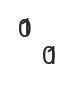

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [251]:
from torch.utils.data.sampler import SequentialSampler
from src.models import FullTCRVAE
model_l2 = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
model_cos = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
model_new = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
model_notriplet = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=128, latent_dim=64)
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')
dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')
loader = dataset.get_dataloader(1024, SequentialSampler)
model_l2 = load_checkpoint(model_l2, '../output/TripletTest/231108_FirstTestTriplet_A3B3_Euclidean_margin_Auto_15k_epochs_5U0XJ/231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_5U0XJ/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_5U0XJ.pt')
model_cos = load_checkpoint(model_cos, '../output/TripletTest/231108_FirstTestTriplet_A3B3_Cosine_margin_Auto_15k_epochs_Qg0vv/231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_Qg0vv/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_FirstTestTriplet_A3B3_margin_Auto_15k_epochs_KFold_0_231109_1016_Qg0vv.pt')
model_notriplet = load_checkpoint(model_notriplet, '../output/2310XX_MoreChains/CDR3_AB_nh_128_wd_1e-4_weights_3to1_LlWGn/CDR3_AB_nh_128_wd_1e-4_weights_3to1_KFold_0_231018_1115_LlWGn/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_CDR3_AB_nh_128_wd_1e-4_weights_3to1_KFold_0_231018_1115_LlWGn.pt')

model.eval()
preds_l2 = predict_model(model_l2, dataset, loader)
preds_new = predict_model(model_new, dataset, loader)
preds_notriplet = predict_model(model_notriplet, dataset, loader)
preds_cos = predict_model(model_cos, dataset, loader)

Reloading best model:
Best epoch: 2978
total: 0.3471359203992122
reconstruction: 0.3236078183448857
kld: 0.011238383888040365
triplet: 0.012289712281555546
seq_accuracy: 0.7950296401977539
v_accuracy: 0
j_accuracy: 0
Reloading best model:
Best epoch: 8493
total: 0.9874765274101749
reconstruction: 0.8348735555000545
kld: 0.0015289650608974054
triplet: 0.15107398977272177
seq_accuracy: 0.49407926201820374
v_accuracy: 0
j_accuracy: 0
Reloading best model:
Best epoch: 23928
Valid loss: {'total': 0.41027834609127495, 'reconstruction': 0.33296063935363684, 'kld': 0.07731769928705748}
total: 0.41027834609127495
reconstruction: 0.33296063935363684
kld: 0.07731769928705748
seq_accuracy: 0.8798987865447998
v_accuracy: 0
j_accuracy: 0


In [208]:
l2=torch.from_numpy(preds_new[zcols].values)
l2_new = torch.cdist(l2, l2)

In [209]:
l2_new

tensor([[0.0000e+00, 2.0558e+01, 2.8420e+01,  ..., 1.9511e+01, 1.4643e+01,
         2.2049e+01],
        [2.0558e+01, 7.8125e-03, 2.4101e+01,  ..., 2.0394e+01, 1.7257e+01,
         1.2885e+01],
        [2.8420e+01, 2.4101e+01, 0.0000e+00,  ..., 3.4027e+01, 2.9563e+01,
         2.2261e+01],
        ...,
        [1.9511e+01, 2.0394e+01, 3.4027e+01,  ..., 5.5243e-03, 1.1527e+01,
         2.0562e+01],
        [1.4643e+01, 1.7257e+01, 2.9563e+01,  ..., 1.1527e+01, 0.0000e+00,
         1.9312e+01],
        [2.2049e+01, 1.2885e+01, 2.2261e+01,  ..., 2.0562e+01, 1.9312e+01,
         0.0000e+00]])

## cosine dist detours

In [93]:
model2 = FullTCRVAE(0, 0,22, 0, 0, 23, 'BL50LO', hidden_dim=64, latent_dim=32)
preds2 = predict_model(model2, dataset, loader)
z2 = torch.from_numpy(preds2[zcols].values)

In [103]:
dot = torch.mm(z2, z2.t())
norms = torch.norm(z2, p=2, dim=1, keepdim=True)
norm2 = norms * norms.t()

In [139]:
from src.metrics import compute_cosine_distance
cos2 = compute_cosine_distance(z2)
cos = compute_cosine_distance(z)
cos2[:5, :5]

tensor([[0.0000, 0.3473, 0.2778, 0.2894, 0.9475],
        [0.3473, 0.0000, 0.6491, 0.3513, 0.7533],
        [0.2778, 0.6491, 0.0000, 0.2269, 0.9140],
        [0.2894, 0.3513, 0.2269, 0.0000, 0.6336],
        [0.9475, 0.7533, 0.9140, 0.6336, 0.0000]])

In [140]:
cos[:5, :5]

tensor([[0.0000, 0.1913, 0.3260, 0.2627, 0.1818],
        [0.1913, 0.0000, 0.1253, 0.1367, 0.1319],
        [0.3260, 0.1253, 0.0000, 0.1269, 0.1726],
        [0.2627, 0.1367, 0.1269, 0.0000, 0.1350],
        [0.1818, 0.1319, 0.1726, 0.1350, 0.0000]])

In [116]:
# Set values less than or equal to 1e-5 to 0
cos2[cos2 <= 1e-5] = 0

# Clamp values to be between 0 and 1
cos2 = torch.clamp(cos2, 0, 1)

In [120]:
manual_cos[manual_cos>1]

tensor([1.0161, 1.0551, 1.0719,  ..., 1.0069, 1.0090, 1.0113])

In [119]:
manual_cos = 1 - (dot / norm2)
manual_cos.max(), manual_cos.min(), manual_cos.median(), manual_cos.mean(), manual_cos.std()

(tensor(1.8429),
 tensor(-1.1921e-07),
 tensor(0.5633),
 tensor(0.6015),
 tensor(0.2607))

In [125]:
def tensor_stats(tensor):
    print(f'max: {tensor.max():.3e}, min: {tensor.min():.3e}, mean: {tensor.mean():.3e}, med: {tensor.median():.3e}, std: {tensor.std():.3e}')
    

In [126]:
tensor_stats(cos)

max: 7.337e-01, min: -1.192e-07, mean: 1.926e-01, med: 1.861e-01, std: 6.693e-02


In [127]:
compute_cosine_distance(z, z, p=2)

tensor([[ 1.1921e-07,  1.9134e-01,  3.2602e-01,  ...,  8.7775e-02,
          8.7753e-02,  1.1952e-01],
        [ 1.9134e-01,  0.0000e+00,  1.2531e-01,  ...,  1.8682e-01,
          1.5491e-01,  2.1118e-01],
        [ 3.2602e-01,  1.2531e-01, -1.1921e-07,  ...,  2.9627e-01,
          2.5814e-01,  3.4465e-01],
        ...,
        [ 8.7775e-02,  1.8682e-01,  2.9627e-01,  ...,  0.0000e+00,
          4.0389e-02,  1.4842e-01],
        [ 8.7753e-02,  1.5491e-01,  2.5814e-01,  ...,  4.0389e-02,
          0.0000e+00,  1.4157e-01],
        [ 1.1952e-01,  2.1118e-01,  3.4465e-01,  ...,  1.4842e-01,
          1.4157e-01,  0.0000e+00]])

In [119]:
manual_cos = 1 - (dot / norm2)
manual_cos.max(), manual_cos.min(), manual_cos.median(), manual_cos.mean(), manual_cos.std()

(tensor(1.8429),
 tensor(-1.1921e-07),
 tensor(0.5633),
 tensor(0.6015),
 tensor(0.2607))

In [110]:
pd.DataFrame(cos2)[range(10)].describe()

,0,1,2,3,4,5,6,7,8,9
count,6.353000e+03,6353.000000,6.353000e+03,6353.000000,6.353000e+03,6353.000000,6.353000e+03,6.353000e+03,6.353000e+03,6353.000000
mean,5.186962e-01,0.517967,5.372647e-01,0.484381,8.233352e-01,0.573597,5.641522e-01,5.747511e-01,6.237338e-01,0.578345
std,1.613321e-01,0.147199,1.742908e-01,0.143024,4.112997e-01,0.235941,2.690619e-01,1.321101e-01,2.855053e-01,0.158008
min,-1.192093e-07,0.000000,1.192093e-07,0.000000,1.192093e-07,0.000000,1.192093e-07,5.960464e-08,5.960464e-08,0.000000
25%,3.981333e-01,0.410297,4.070694e-01,0.379141,4.841430e-01,0.389547,3.445272e-01,4.807523e-01,3.871662e-01,0.465400
50%,4.947702e-01,0.515969,5.147728e-01,0.473621,8.087338e-01,0.534148,5.148104e-01,5.719835e-01,5.926954e-01,0.553510
75%,6.212136e-01,0.622212,6.477591e-01,0.578828,1.159658e+00,0.728963,7.463725e-01,6.672796e-01,8.396362e-01,0.672752
max,1.160918e+00,1.127093,1.282438e+00,1.036864,1.740401e+00,1.417287,1.398061e+00,1.007913e+00,1.427207e+00,1.154190


In [75]:
zcols = [x for x in train_preds.columns if x.startswith('z_')]
z = torch.from_numpy(preds[zcols].values)
dists = torch.cdist(z,z)
dist_matrix = pd.DataFrame(dists, 
                           columns = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()],
                           index = [x['A3']+'-'+x['B3'] for _, x in preds.iterrows()])
dist_matrix['set'] = df['set'].values
dist_matrix['label'] = df['peptide'].values
dist_matrix['binder'] = df['binder'].values
dist_matrix['origin'] = df['origin'].values

## Plot DF

In [161]:
zcols = [z for z in preds_l2.columns if z.startswith('z_')]
z_l2 = preds_l2[zcols]
z_cos = preds_cos[zcols]

In [164]:
from sklearn.manifold import TSNE
tsne_l2 = TSNE(n_components=2, n_iter=2000, metric='euclidean', perplexity=30)
latent_tsne_l2 = tsne_l2.fit_transform(z_l2)

tsne_cos = TSNE(n_components=2, n_iter=2000, metric='cosine', perplexity=30)
latent_tsne_cos = tsne_cos.fit_transform(z_cos)

In [170]:
from umap import UMAP
umap_l2 = UMAP(n_components=2, n_epochs=500, learning_rate=0.79)
latent_umap_l2 = umap_l2.fit_transform(z)
umap_cos = UMAP(n_components=2, n_epochs=500, learning_rate=0.79, metric='cosine')
latent_umap_cos = umap_cos.fit_transform(z)

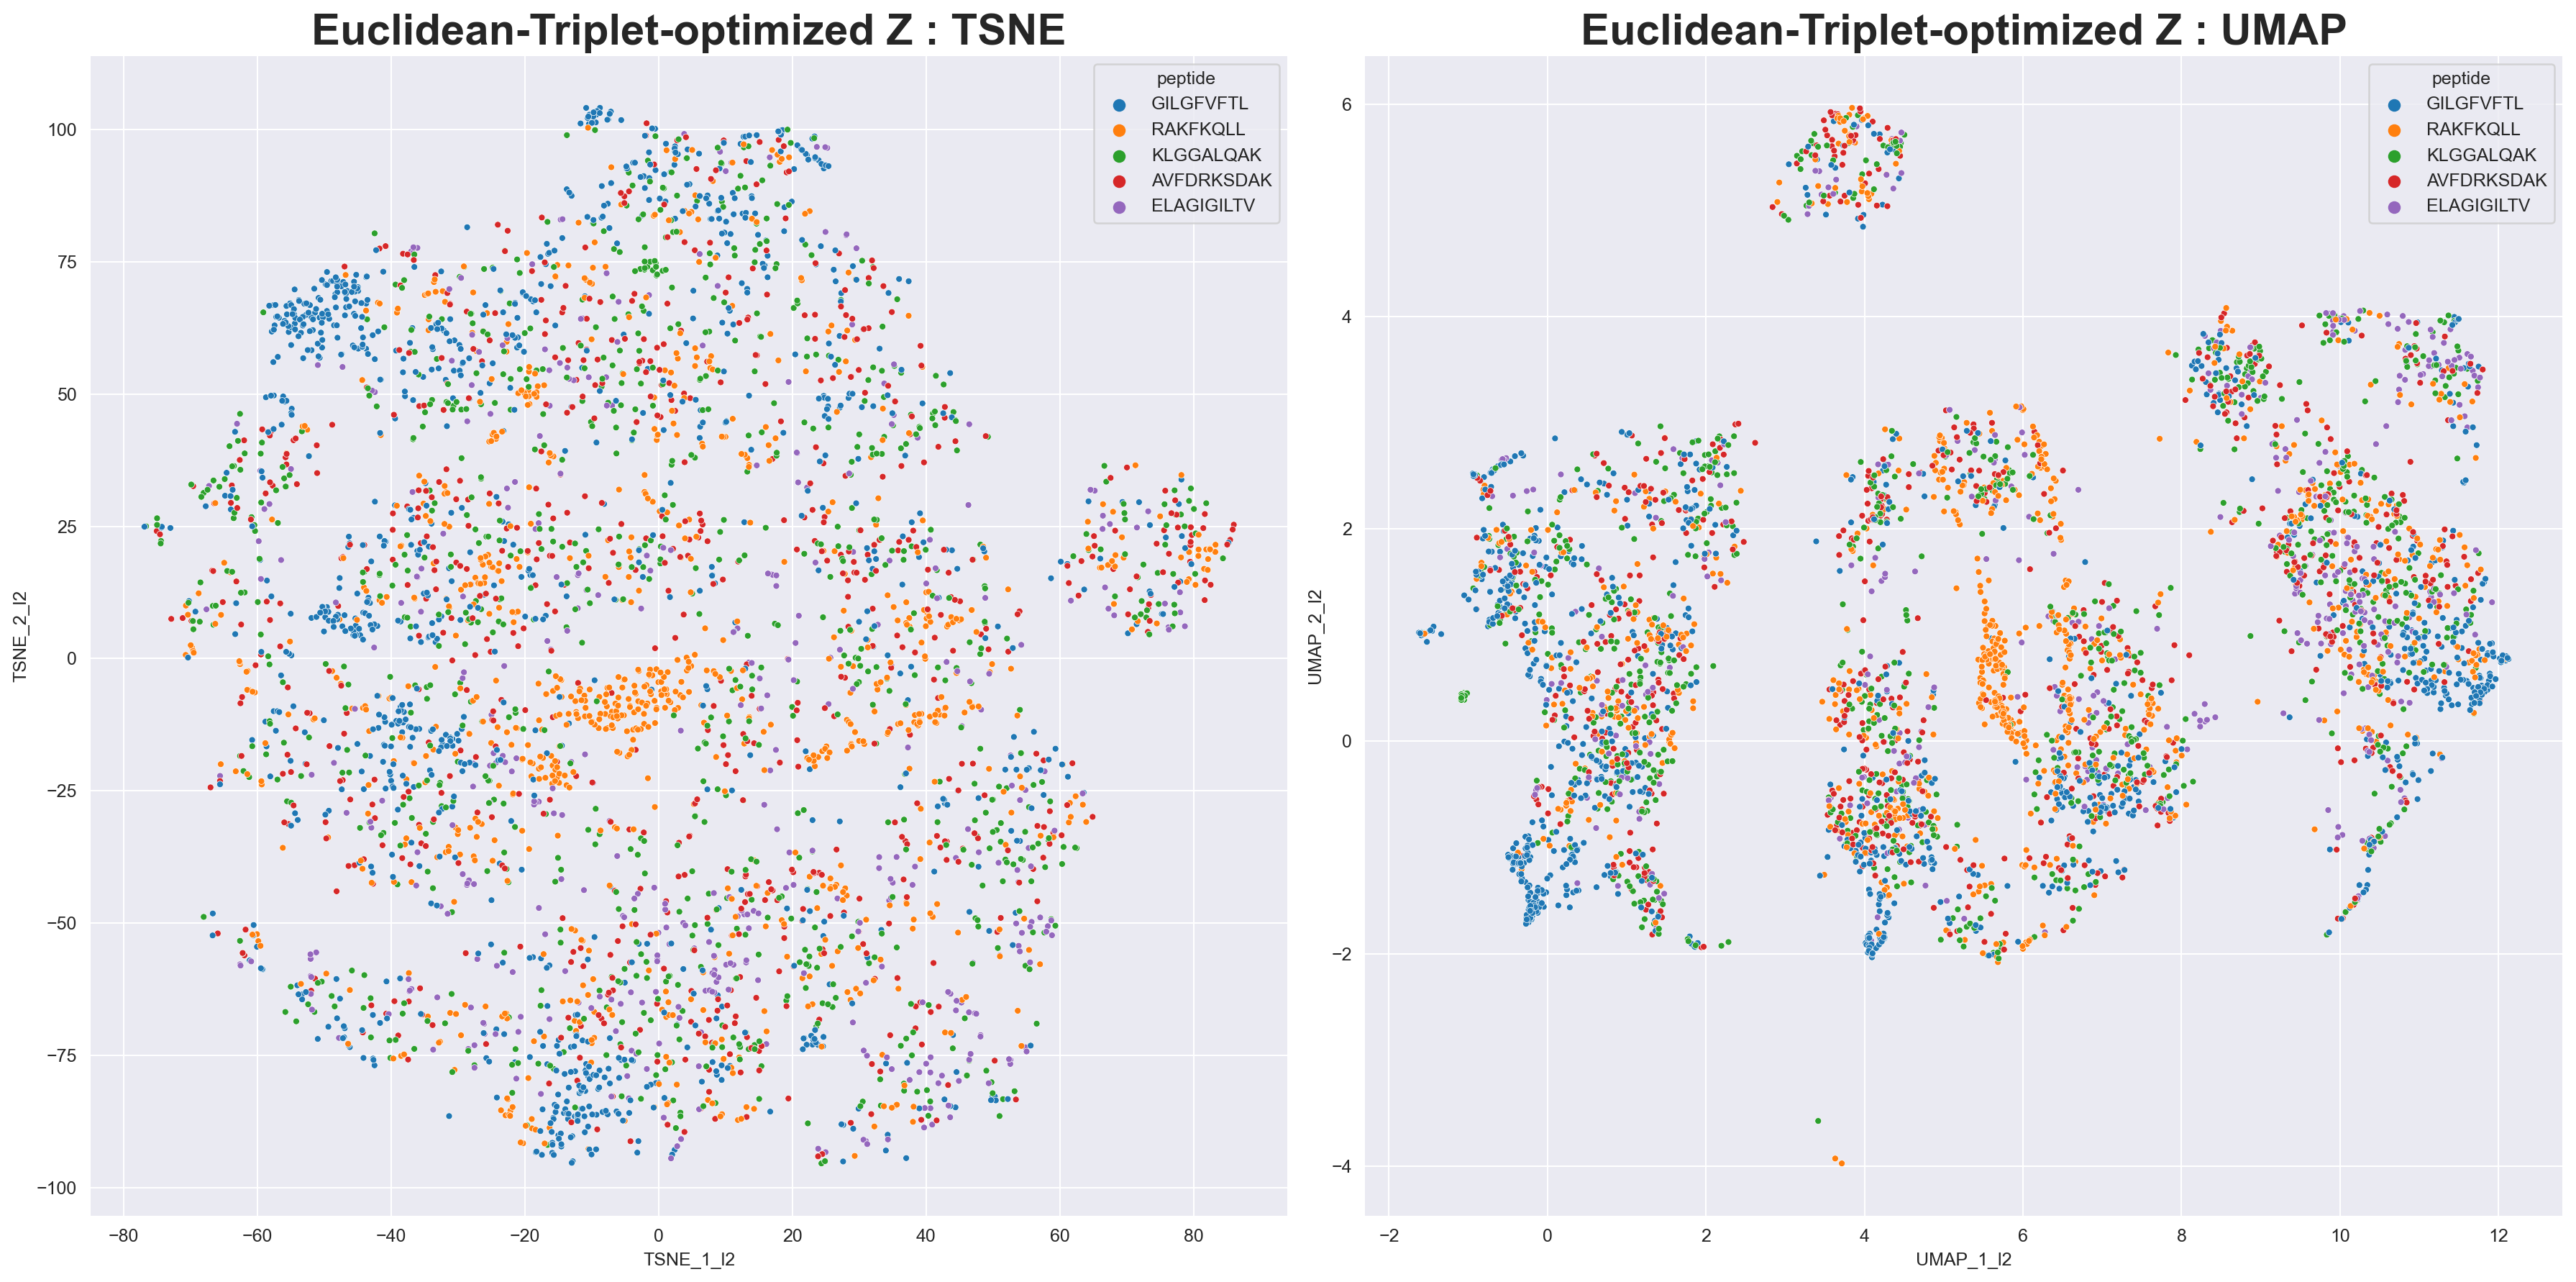

In [167]:
df[['TSNE_1_l2', 'TSNE_2_l2']] = latent_tsne_l2
df[['UMAP_1_l2', 'UMAP_2_l2']] = latent_umap_l2
f,a = plt.subplots(1,2, figsize=(20,10))
a = a.ravel()
top5=df.groupby('peptide').agg(count=('B3', 'count')).sort_values('count',ascending=False).head(5).index
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1_l2', y='TSNE_2_l2',  s=13, hue='peptide', hue_order=top5, ax = a[0])
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'), 
                x='UMAP_1_l2', y='UMAP_2_l2',  s=13, hue='peptide', hue_order=top5, ax = a[1])

a[0].set_title('Euclidean-Triplet-optimized Z : TSNE', fontsize=24, fontweight='semibold')
a[1].set_title('Euclidean-Triplet-optimized Z : UMAP', fontsize=24, fontweight='semibold')
# a[0].legend('', frame_on=False)

# f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig('../output/TripletTest/Euclidean_Fold0Model_firstTest_TSNE_UMAP.png', dpi=200, bbox_inches='tight')


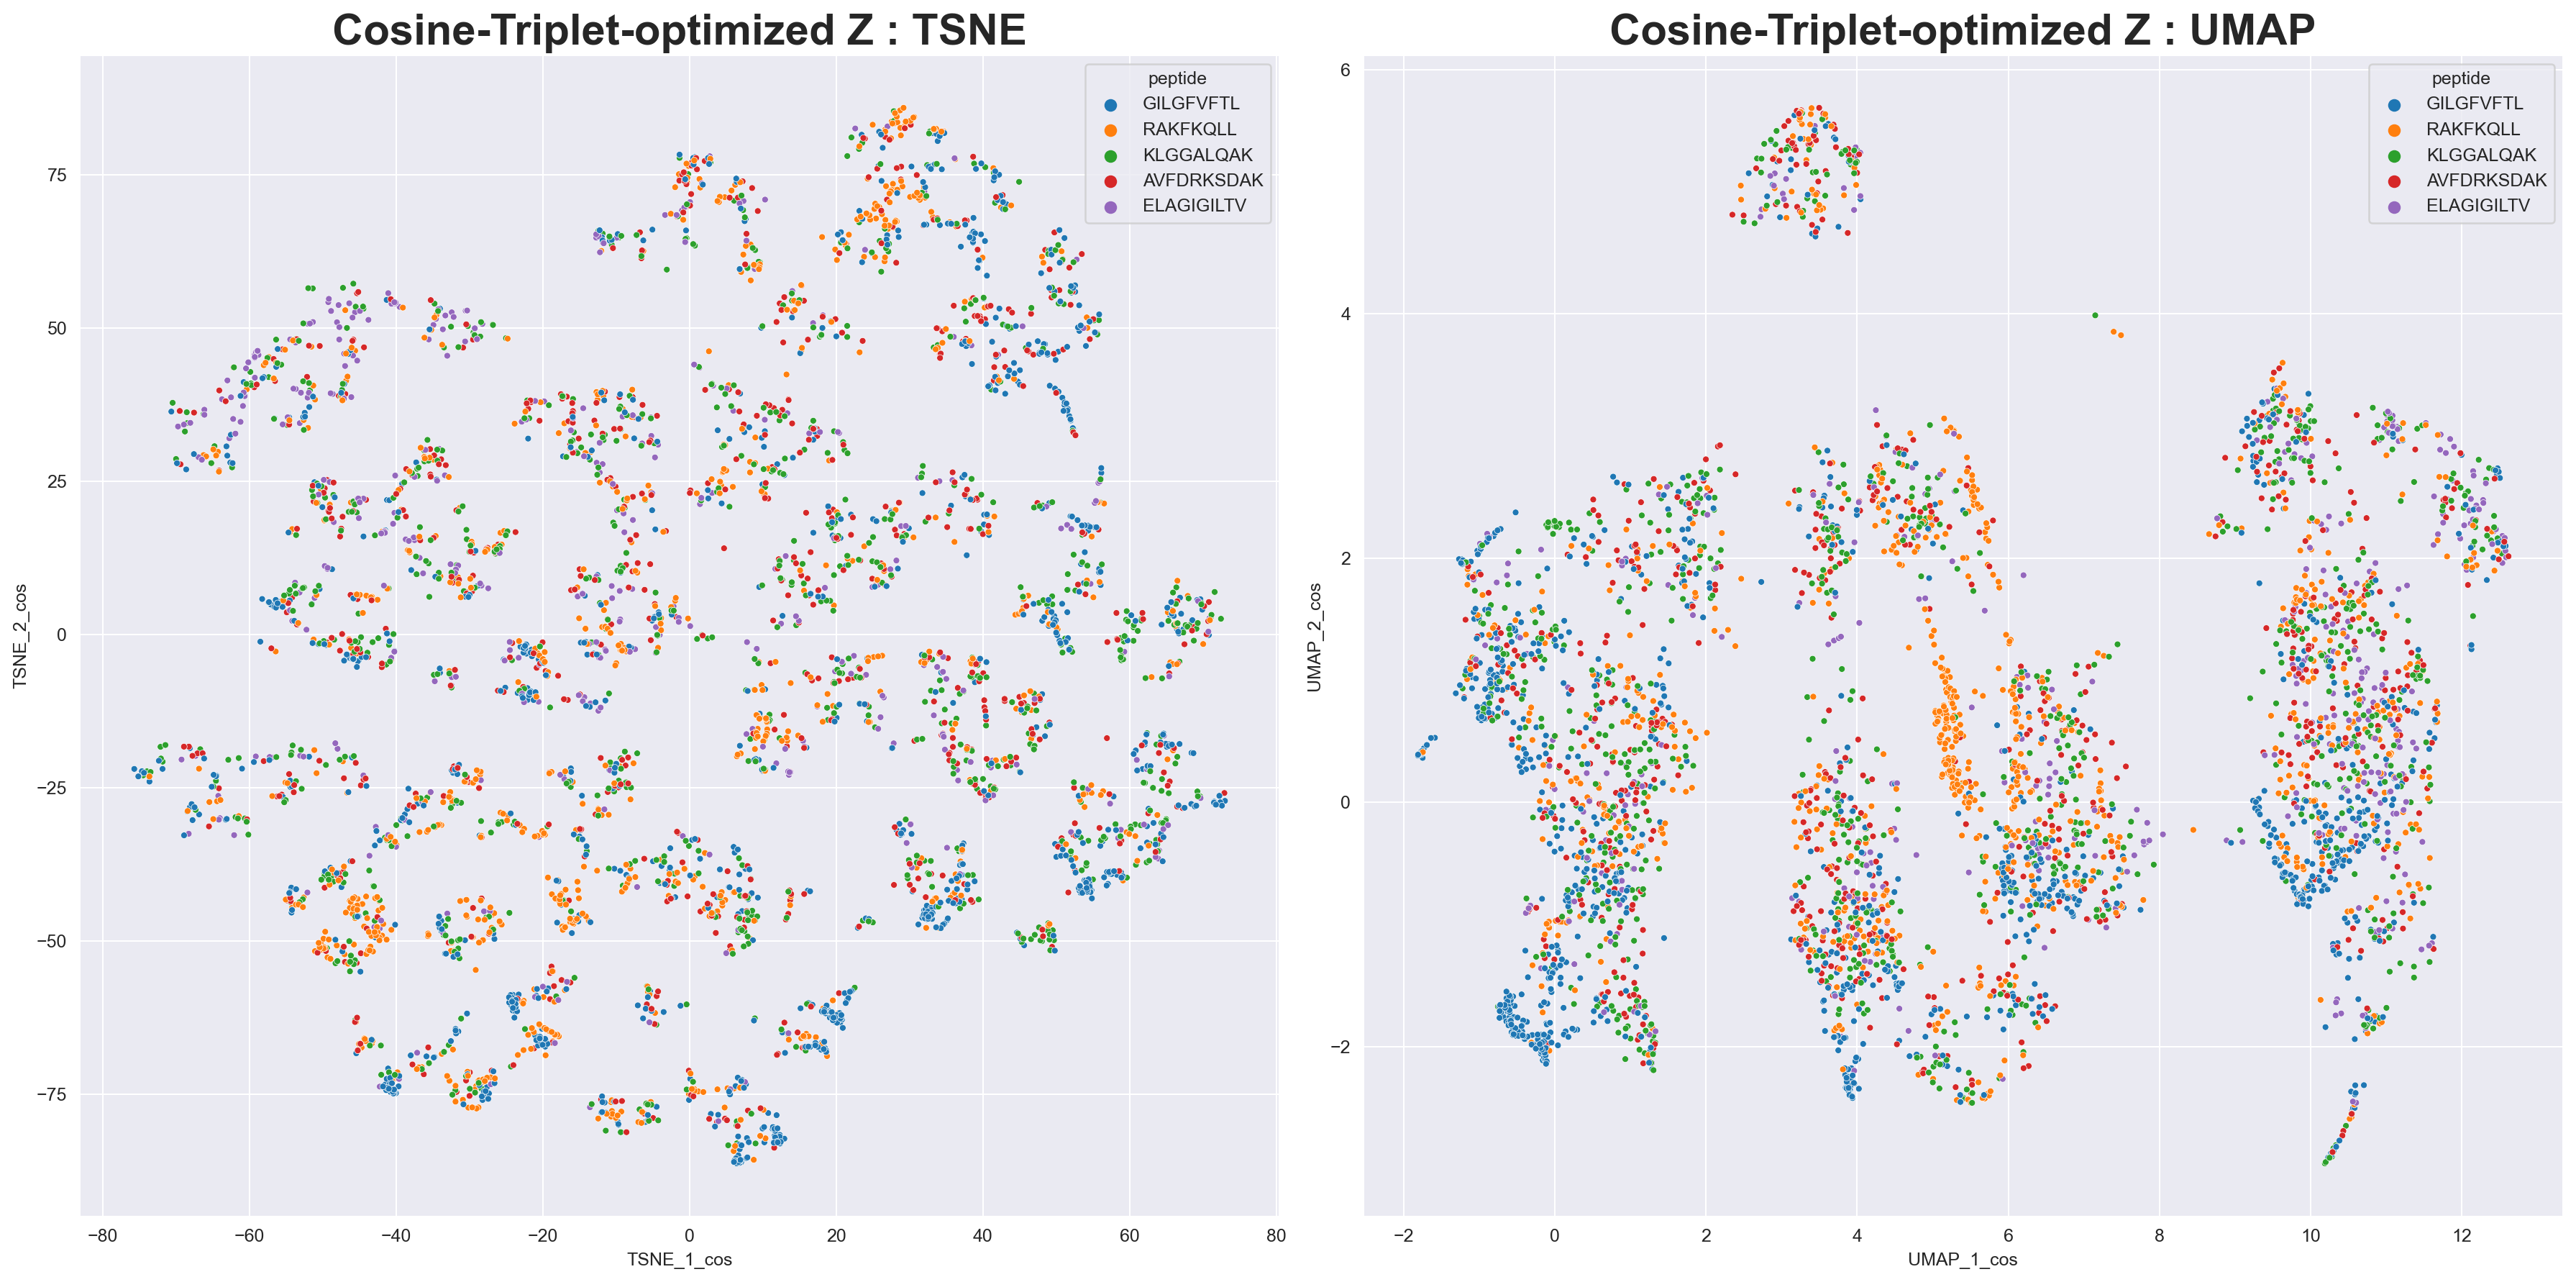

In [171]:
f,a = plt.subplots(1,2, figsize=(20,10))
df[['TSNE_1_cos', 'TSNE_2_cos']] = latent_tsne_cos
df[['UMAP_1_cos', 'UMAP_2_cos']] = latent_umap_cos
a = a.ravel()
top5=df.groupby('peptide').agg(count=('B3', 'count')).sort_values('count',ascending=False).head(5).index
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'),
                x='TSNE_1_cos', y='TSNE_2_cos',  s=13, hue='peptide', hue_order=top5, ax = a[0])
sns.scatterplot(data=df.query('peptide in @top5'), #.query('GroundTruth!="immrep_negs"'), 
                x='UMAP_1_cos', y='UMAP_2_cos',  s=13, hue='peptide', hue_order=top5, ax = a[1])

a[0].set_title('Cosine-Triplet-optimized Z : TSNE', fontsize=24, fontweight='semibold')
a[1].set_title('Cosine-Triplet-optimized Z : UMAP', fontsize=24, fontweight='semibold')
# a[0].legend('', frame_on=False)

# f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3', fontsize=26, fontweight='semibold')
f.tight_layout()
f.savefig('../output/TripletTest/Cosine_Fold0Model_firstTest_TSNE_UMAP.png', dpi=200, bbox_inches='tight')


## TCRbase

In [197]:
# Take the validation (Gil only)
# Compare against train (All peps)
# get 1-dist as score
def get_tcrbase_method(tcr, ref):
    # here take the top1 instead of percent
    best = ref[tcr].sort_values().head(1)
    best_name = best.index[0]
    best_sim = best.item()
    label = ref.loc[best_name]['label']
    return label, best_name, best_sim

def do_tcrbase(dist_matrix, ref, label='GILGFVFTL'):
    output = dist_matrix.drop(columns=[x for x in dist_matrix.columns if x !='label']).copy().reset_index().rename(columns={'index':'tcr'})

    output[['similar_label', 'best_name', 'best_sim']] = output.apply(lambda x: get_tcrbase_method(x['tcr'], ref = ref), 
                                                                                  axis=1, result_type='expand')
    output['y_true'] = (output['label'] == label).astype(int)
    output['score'] = 100 - output['best_sim']
    return output

In [175]:
z_l2 = torch.from_numpy(preds_l2[zcols].values)
dists_l2 = torch.cdist(z_l2,z_l2)
dist_matrix_l2 = pd.DataFrame(dists_l2, 
                           columns = [x['A3']+'-'+x['B3'] for _, x in preds_l2.iterrows()],
                           index = [x['A3']+'-'+x['B3'] for _, x in preds_l2.iterrows()])
dist_matrix_l2['set'] = df['set'].values
dist_matrix_l2['label'] = df['peptide'].values
dist_matrix_l2['binder'] = df['binder'].values
dist_matrix_l2['origin'] = df['origin'].values

In [217]:
train_l2 = dist_matrix_l2.query('set=="train" and label=="GILGFVFTL" and binder == 1')
valid_l2 = dist_matrix_l2.query('set=="valid" and binder == 1')
len(train_l2), len(valid_l2)

(900, 1274)

In [220]:
tcrbase_l2 = do_tcrbase(valid_l2, train_l2)

In [212]:
train_cos = dist_matrix_cos.query('set=="train" and label=="GILGFVFTL" and binder == 1')
valid_cos = dist_matrix_cos.query('set=="valid" and binder == 1')

In [214]:
tcrbase_cos = do_tcrbase(valid_cos, train_cos)

In [243]:
df_save = df.copy()
train_save = df_save.query('set=="train" and peptide=="GILGFVFTL" and binder==1')
valid_save = df_save.query('set=="valid" and binder==1')

In [244]:
alphasort = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'peptide']
numsort = ['A1', 'B1', 'A2', 'B2', 'A3', 'B3', 'peptide']

train_save.to_csv('../data/baselines/231127_tcrbase_train.tsv', index=False, header = False,
                  columns = alphasort,
                  sep = '\t')
valid_save.to_csv('../data/baselines/231127_tcrbase_valid.tsv', index=False, header = False,
                  columns = alphasort,
                  sep = '\t')

In [247]:
tcrbase_results = pd.read_csv('../data/baselines/TCRbase_results_fold0.csv')
tcrbase_results_query_idx = tcrbase_results.set_index(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).index
tcrbase_results['true_label'] = valid_save.set_index(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).loc[tcrbase_results_query_idx]['peptide'].values
tcrbase_results['y_true'] = (tcrbase_results['true_label'] == 'GILGFVFTL').astype(int)
tcrbase_results['score'] = tcrbase_results['Prediction']

In [252]:
z_notriplet = torch.from_numpy(preds_notriplet[zcols].values)
dists_notriplet = torch.cdist(z_notriplet,z_notriplet)
dist_matrix_notriplet = pd.DataFrame(dists_notriplet, 
                           columns = [x['A3']+'-'+x['B3'] for _, x in preds_notriplet.iterrows()],
                           index = [x['A3']+'-'+x['B3'] for _, x in preds_notriplet.iterrows()])
dist_matrix_notriplet['set'] = df['set'].values
dist_matrix_notriplet['label'] = df['peptide'].values
dist_matrix_notriplet['binder'] = df['binder'].values
dist_matrix_notriplet['origin'] = df['origin'].values

In [253]:
train_notriplet = dist_matrix_notriplet.query('set=="train" and label=="GILGFVFTL" and binder == 1')
valid_notriplet = dist_matrix_notriplet.query('set=="valid" and binder == 1')
len(train_notriplet), len(valid_notriplet)

(900, 1274)

In [254]:
tcrbase_notriplet = do_tcrbase(valid_notriplet, train_notriplet)

In [298]:
z_l1 = torch.from_numpy(preds_l2[zcols].values)
dists_l1 = torch.cdist(z_l1,z_l1, p=1.0)
dist_matrix_l1 = pd.DataFrame(dists_l1, 
                           columns = [x['A3']+'-'+x['B3'] for _, x in preds_l2.iterrows()],
                           index = [x['A3']+'-'+x['B3'] for _, x in preds_l2.iterrows()])
dist_matrix_l1['set'] = df['set'].values
dist_matrix_l1['label'] = df['peptide'].values
dist_matrix_l1['binder'] = df['binder'].values
dist_matrix_l1['origin'] = df['origin'].values
train_l1 = dist_matrix_l1.query('set=="train" and label=="GILGFVFTL" and binder == 1')
valid_l1 = dist_matrix_l1.query('set=="valid" and binder == 1')
len(train_l1), len(valid_l1)
tcrbase_l1 = do_tcrbase(valid_l1, train_l1)

In [299]:
from sklearn.metrics import roc_auc_score
print('without triplet loss L2-distances matrix (TCRBase)')
print('AUC:\t',round(roc_auc_score(tcrbase_notriplet['y_true'], tcrbase_notriplet['score']), 5))
print('AUC-01:\t',round(roc_auc_score(tcrbase_notriplet['y_true'], tcrbase_notriplet['score'], max_fpr=0.1), 5))
print('using l2-triplet optimized, L1-distances matrix (TCRBase)')
print('AUC:\t',round(roc_auc_score(tcrbase_l1['y_true'], tcrbase_l1['score']), 5))
print('AUC-01:\t',round(roc_auc_score(tcrbase_l1['y_true'], tcrbase_l1['score'], max_fpr=0.1), 5))
print('using l2-triplet optimized L2-distances matrix (TCRBase)')
print('AUC:\t',round(roc_auc_score(tcrbase_l2['y_true'], tcrbase_l2['score']), 5))
print('AUC-01:\t',round(roc_auc_score(tcrbase_l2['y_true'], tcrbase_l2['score'], max_fpr=0.1), 5))
print('using cos-triplet optimized cosine-distances matrix (TCRBase)')
print('AUC:\t',round(roc_auc_score(tcrbase_cos['y_true'], tcrbase_cos['score']),5))
print('AUC-01:\t',round(roc_auc_score(tcrbase_cos['y_true'], tcrbase_cos['score'], max_fpr=0.1),5))
print('using TCRBase webserver')
print('AUC:\t',round(roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score']),5))
print('AUC-01:\t',round(roc_auc_score(tcrbase_results['y_true'], tcrbase_results['score'], max_fpr=0.1),5))

without triplet loss L2-distances matrix (TCRBase)
AUC:	 0.70022
AUC-01:	 0.63305
using l2-triplet optimized, L1-distances matrix (TCRBase)
AUC:	 0.73407
AUC-01:	 0.67149
using l2-triplet optimized L2-distances matrix (TCRBase)
AUC:	 0.73668
AUC-01:	 0.66785
using cos-triplet optimized cosine-distances matrix (TCRBase)
AUC:	 0.67747
AUC-01:	 0.60945
using TCRBase webserver
AUC:	 0.76556
AUC-01:	 0.68153


In [295]:
import random
random.seed(None)
init = random.randint(0,1000)
print(f'Initial seed: {init}')
for _ in range(10):
    random.seed(init)
    new_rand = random.randint(0, 1000)
    torch.manual_seed(new_rand)
    layer = nn.Linear(100,10)
    print(f'Seed = {new_rand}, weight = {layer.weight[0,:5]}')
    init = new_rand

Initial seed: 77
Seed = 818, weight = tensor([ 0.0970,  0.0161, -0.0730, -0.0898,  0.0432], grad_fn=<SliceBackward0>)
Seed = 481, weight = tensor([ 0.0868,  0.0814,  0.0506, -0.0950,  0.0752], grad_fn=<SliceBackward0>)
Seed = 694, weight = tensor([-0.0794,  0.0331,  0.0966,  0.0413, -0.0761], grad_fn=<SliceBackward0>)
Seed = 719, weight = tensor([-0.0079, -0.0541,  0.0556,  0.0860,  0.0321], grad_fn=<SliceBackward0>)
Seed = 283, weight = tensor([ 0.0877,  0.0014,  0.0231,  0.0147, -0.0898], grad_fn=<SliceBackward0>)
Seed = 742, weight = tensor([-0.0343,  0.0859,  0.0893,  0.0792, -0.0764], grad_fn=<SliceBackward0>)
Seed = 425, weight = tensor([-0.0876,  0.0207,  0.0925,  0.0770, -0.0183], grad_fn=<SliceBackward0>)
Seed = 429, weight = tensor([ 0.0920,  0.0583,  0.0344, -0.0461,  0.0796], grad_fn=<SliceBackward0>)
Seed = 608, weight = tensor([ 0.0658,  0.0431, -0.0439, -0.0223, -0.0580], grad_fn=<SliceBackward0>)
Seed = 134, weight = tensor([ 0.0439,  0.0619,  0.0255, -0.0014,  0.0406],